In [ ]:
import os
import logging

logging.basicConfig(level=logging.ERROR)

import pandas as pd
from tqdm import tqdm

from src.util import seed_everything, update_avg
from src.config import SEED, INTERIM_DATA_DIR, OPENAI_API_KEY
from src.metrics import calculate_all
from src.data.dataset import create_loaders
from src.models.openai_model import ZeroShotModel

In [2]:
if not INTERIM_DATA_DIR.exists():
    os.chdir("..")

In [3]:
seed_everything(SEED)

In [4]:
BATCH_SIZE = 32
NUM_BATCHES = 3

In [5]:
train_loader, val_loader, test_loader = create_loaders(
    pd.read_csv(INTERIM_DATA_DIR / "swapped.csv"), batch_size=BATCH_SIZE
)

In [6]:
model = ZeroShotModel(OPENAI_API_KEY)

In [7]:
all_predictions = []
avg_non_tox = 0
avg_bert = 0
avg_bleu = 0
for i, batch in (pbar := tqdm(enumerate(test_loader), total=NUM_BATCHES)):
    inputs, target = batch
    test_pred = model.predict(inputs)
    all_predictions.extend(test_pred)
    non_tox, bert, bleu = calculate_all(inputs, test_pred, target, BATCH_SIZE)
    avg_non_tox = update_avg(avg_non_tox, non_tox, i)
    avg_bert = update_avg(avg_bert, bert, i)
    avg_bleu = update_avg(avg_bleu, bleu, i)
    pbar.set_description(f"{avg_non_tox=:.3f} {avg_bert=:.3f} {avg_bleu=:.3f}")
    if i + 1 >= NUM_BATCHES:
        break

  0%|          | 0/3 [00:00<?, ?it/s]Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
avg_non_tox=0.750 avg_bert=0.506 avg_bleu=0.122:  67%|██████▋   | 2/3 [00:36<00:18, 18.45s/it]


In [8]:
all_predictions

['He should be reimbursed for the rug.',
 'Hold on and remain quiet.',
 'This game yielded no results.',
 "Examine the evidence carefully today and send it to Ed Blake's laboratory in California.",
 'I chose to be polite to that unattractive girl who had been bothering me.',
 "That's the one you're looking for.",
 '"It\'s better to be fifty yards away than three feet away with his life on the line, right?" Said Cohen.',
 'Your former partner is a habitual drug user.',
 'Come on, give it a shot!',
 'Dad would have thrown out ten of them.',
 'We all have difficulties, so what should we do?',
 'Are you joking now?',
 "And he's so overweight, and he's attempting to hide behind the slim one.",
 'Most likely South African single-use items.',
 "He's going to explode the house.",
 'As per Cal Tech, this person, Webber, is brilliant... but a bit of a lunatic.',
 'But whoever they are, they are in a lot of trouble since they are playing in the same area as June and Lebbe and who knows who else.'

In [11]:
all_inputs = sum((b[0] for b in list(test_loader)[:3]), [])

In [12]:
all_inputs

['He should compensate me for the fucking rug.',
 'Shut your mouth and just hold on.',
 'stupid game, I got nothing.',
 "Test the goddamn evidence today and Fedex the result to Ed Blake's lab in California.",
 "I would even, I decided, be nice to that ugly girl who'd been annoying me.",
 "That's your shooter.",
 '"better fifty yards on his right than two or three meters with his balls in a minute, right?" Said Cohen.',
 'Your ex-girlfriend is a practicing drug addict.',
 'come on, one shot!',
 'dad would have thrown ten of them.',
 'We all have fucking problems, but what now?',
 "You're gonna fucking joke now?",
 "and he's so fat, and he's trying to hide behind the skinny.",
 'Probably South African disposables.',
 "He's gonna blow up the house.",
 'according to Cal Tech, this guy, Webber, genius... but quite a nutcase.',
 "but whoever he is, he's in deep shit because he's playing in the sandbox with June and Lebbe and God knows who.",
 "Julia Roberts should make a truly realistic film

# Visualize word clouds

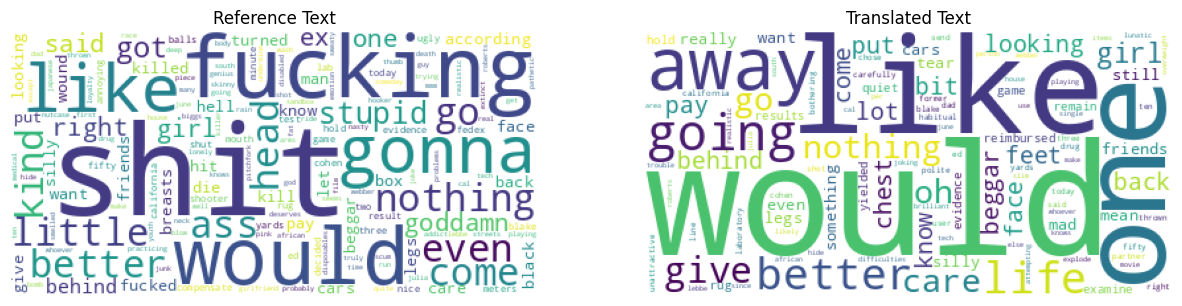

In [16]:
import matplotlib.pyplot as plt
from src.visualization.make_wordcloud import make_wordcloud

_, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(make_wordcloud(pd.Series(all_inputs)))
axes[0].axis("off")
axes[0].set_title("Reference Text")

axes[1].imshow(make_wordcloud(pd.Series(all_predictions)))
axes[1].axis("off")
axes[1].set_title("Translated Text")
plt.show()

In [17]:
len(all_predictions)

96